In [67]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [68]:
# Load the provided CSV file
file_path = r"C:\\Users\\Ericm\\PycharmProjects\\wageData\\.venv\\Scripts\\SDCountyEmployee_data_cleaned_adjusted.csv"
df = pd.read_csv(file_path, encoding='latin1')

df

,Year,EmployerName,DepartmentOrSubdivision,Position,MinPositionSalary,MaxPositionSalary,ReportedBaseWage,RegularPay,OvertimePay,LumpSumPay,OtherPay,TotalWages,DefinedBenefitPlanContribution,EmployeesRetirementCostCovered,DeferredCompensationPlan,HealthDentalVision,TotalRetirementAndHealthContribution,PensionFormula
0,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,56247.0,NaN,NaN,NaN,NaN,56247.000000,NaN,2197.0,NaN,4164.000000,6361.000000,3@60
1,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,65839.0,NaN,NaN,NaN,NaN,65839.000000,NaN,2278.0,NaN,4164.000000,6442.000000,3@60
2,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,67338.0,NaN,NaN,NaN,NaN,67338.000000,NaN,4889.0,NaN,8868.000000,13757.000000,3@60
3,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,66206.0,NaN,NaN,NaN,NaN,66206.000000,NaN,4889.0,NaN,8868.000000,13757.000000,3@60
4,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,63634.0,NaN,NaN,NaN,NaN,63634.000000,NaN,2221.0,NaN,4164.000000,6385.000000,3@60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153239,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,31284.738929,13150.250241,1322.981218,3388.071112,49146.041500,4683.592901,NaN,NaN,2612.166215,7295.759115,2.7% @ 57
153240,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,23877.029832,711.128808,1750.362590,3022.649477,29361.170708,3491.572038,NaN,NaN,2168.590820,5660.162857,2.7% @ 57
153241,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,31284.738929,15075.930726,1322.981218,3388.071112,51071.721984,4683.592901,NaN,NaN,2612.166215,7295.759115,2.7% @ 57
153242,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,2693.136327,897.712109,215.450906,NaN,3806.299342,373.870690,NaN,NaN,650.577246,1024.447936,2.7% @ 57


In [88]:
# Define the keywords for positions to include and exclude
include_keywords_police = ['Police Officer', 'Police Detective', 'Police Agent', 'Police Corporal',
                    'Police Sergeant', 'Police Lieutenant', 'Police Captain', 'Police Chief', 'Chief of Police']
exclude_keywords_police = ['Assistant', 'Secretary', 'Assist', 'Asst', 'Trainee', 'tied', 'Reserve', 'Temp', 'Security', 'terminal', 'Terminal']

include_keywords_engineer = ['Engineer']

exclude_keywords_engineer = ['Assistant', 'Assist', 'Asst']

include_keywords_fire = ['Firefighter', 'Fire  Chief']

exclude_keywords_fire = []

# Filter for positions that contain one of the include keywords
include_filter = df['Position'].str.contains('|'.join(include_keywords_police), case=False, na=False)

# Exclude positions containing the exclude keywords
exclude_filter = ~df['Position'].str.contains('|'.join(exclude_keywords_police), case=False, na=False)

# Apply both filters
filtered_df = df[include_filter & exclude_filter]

#filtered_df.to_csv(r"C:\Users/Ericm\PycharmProjects\wageData\.venv\Scripts\EngineerWageDataAdjusted.csv")

filtered_df

,Year,EmployerName,DepartmentOrSubdivision,Position,MinPositionSalary,MaxPositionSalary,ReportedBaseWage,RegularPay,OvertimePay,LumpSumPay,OtherPay,TotalWages,DefinedBenefitPlanContribution,EmployeesRetirementCostCovered,DeferredCompensationPlan,HealthDentalVision,TotalRetirementAndHealthContribution,PensionFormula
56146,2009,Carlsbad,Pol Investigations,Police Corporal,67010.000000,81452.000000,97879.0,NaN,NaN,NaN,NaN,97879.000000,NaN,7180.0,NaN,7608.000000,14788.000000,3% @ 50
56147,2009,Carlsbad,Pol Investigations,Police Corporal,67010.000000,81452.000000,134624.0,NaN,NaN,NaN,NaN,134624.000000,NaN,6896.0,NaN,12276.000000,19172.000000,3% @ 50
56148,2009,Carlsbad,Pol Investigations,Police Corporal,67010.000000,81452.000000,102692.0,NaN,NaN,NaN,NaN,102692.000000,NaN,7053.0,NaN,7608.000000,14661.000000,3% @ 50
56149,2009,Carlsbad,Pol Investigations,Police Corporal,67010.000000,81452.000000,108080.0,NaN,NaN,NaN,NaN,108080.000000,NaN,7178.0,NaN,12276.000000,19454.000000,3% @ 50
56150,2009,Carlsbad,Pol Investigations,Police Corporal,67010.000000,81452.000000,95594.0,NaN,NaN,NaN,NaN,95594.000000,NaN,7303.0,NaN,10092.000000,17395.000000,3% @ 50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152563,2023,San Diego,Police,Police Sergeant,78277.679543,94636.458474,NaN,87504.047758,52396.815466,4804.696024,10507.104158,155212.663406,16287.666051,NaN,NaN,5628.478901,21916.144951,2.5@50;2.6@51;2.7@52;2.8@53;2.9@54;3@55
152564,2023,San Diego,Police,Police Sergeant,78277.679543,94636.458474,NaN,42592.391061,17103.703960,NaN,59479.940027,119176.035047,16849.528218,NaN,NaN,5668.611913,22518.140130,2.5@50;2.6@51;2.7@52;2.8@53;2.9@54;3@55
152565,2023,San Diego,Police,Police Sergeant,78277.679543,94636.458474,NaN,43680.910998,26127.294852,316.839568,59764.391550,129889.436968,17242.409282,NaN,NaN,NaN,17242.409282,2.5@50;2.6@51;2.7@52;2.8@53;2.9@54;3@55
152566,2023,San Diego,Police,Police Sergeant,78277.679543,94636.458474,NaN,82471.931333,12311.681518,6483.241646,11293.570374,112560.424871,15205.482905,NaN,NaN,6351.577203,21557.060108,2.5@50;2.6@51;2.7@52;2.8@53;2.9@54;3@55


In [89]:
filtered_df['Position'].unique()

array(['Police Corporal', 'Police Lieutenant', 'Police Officer',
       'Police Sergeant', 'Police Captain', 'Police Chief',
       'Police Agent', 'Chief Of Police', 'Chief Of Police (Hourly)',
       'Senior Police Officer', 'Police Captain \xa0', 'Police Chief\xa0',
       'Police Lieutenant\xa0', 'Police Detective', 'Police Officer II',
       'Police Officer I', 'Police Officer III', 'Police Captain 13%',
       'Police Chief 7.5%', 'Police Lieutenant 13%',
       'Police Lieutenant 5%', 'Police Lieutenant 7.5%',
       'Police Officer 2.5%', 'Police Officer 5%', 'Police Sergeant 5%',
       'Police Officer Recruit', 'Police Officer 2', 'Police Officer 1',
       'Police Officer 3', 'H/Ret Annuitant Police Officer',
       'Police Sergeant -Of', 'Police Lieutenant - Pos 1731',
       'Police Captain 10%', 'Police Captain 7.5%', 'Police Corporal 10%',
       'Police Lieutenant 10%', 'Police Officer 10%', 'Police Officer 3%',
       'Police Sergeant 10%', 'Police Sergeant 15%', 'Pol

In [90]:
grouped_filtered_df = filtered_df.groupby(['Year', 'EmployerName']).agg(
    PositionCount=('Position', 'size'),
    MeanTotalWages=('TotalWages', 'mean')
).reset_index()

grouped_filtered_df.columns = ['Year', 'City', 'NumEmpls', 'MeanTotWage']
grouped_filtered_df

,Year,City,NumEmpls,MeanTotWage
0,2009,Carlsbad,119,102643.445378
1,2009,Chula Vista,100,103070.420000
2,2009,Coronado,43,79584.000000
3,2009,El Cajon,103,86560.427184
4,2009,Escondido,159,96697.710692
...,...,...,...,...
129,2023,Escondido,154,97877.887273
130,2023,La Mesa,71,100411.476915
131,2023,National City,92,97450.720884
132,2023,Oceanside,221,98788.809068


In [95]:

grouped_filtered_df['NumEmpls%Chg'] = grouped_filtered_df.groupby(['City'])['NumEmpls'].pct_change()
grouped_filtered_df['MeanTotWage%Chg'] = grouped_filtered_df.groupby(['City'])['MeanTotWage'].pct_change()

#grouped_filtered_df.to_csv(r"C:\Users/Ericm\PycharmProjects\wageData\.venv\Scripts\Engineer_RoC.csv")

grouped_filtered_df

,Year,City,NumEmpls,MeanTotWage,NumEmpls%Chg,MeanTotWage%Chg
0,2009,Carlsbad,119,102643.445378,NaN,NaN
1,2009,Chula Vista,100,103070.420000,NaN,NaN
2,2009,Coronado,43,79584.000000,NaN,NaN
3,2009,El Cajon,103,86560.427184,NaN,NaN
4,2009,Escondido,159,96697.710692,NaN,NaN
...,...,...,...,...,...,...
129,2023,Escondido,154,97877.887273,0.026667,0.018105
130,2023,La Mesa,71,100411.476915,0.000000,-0.030897
131,2023,National City,92,97450.720884,0.022222,0.029381
132,2023,Oceanside,221,98788.809068,-0.026432,-0.029405


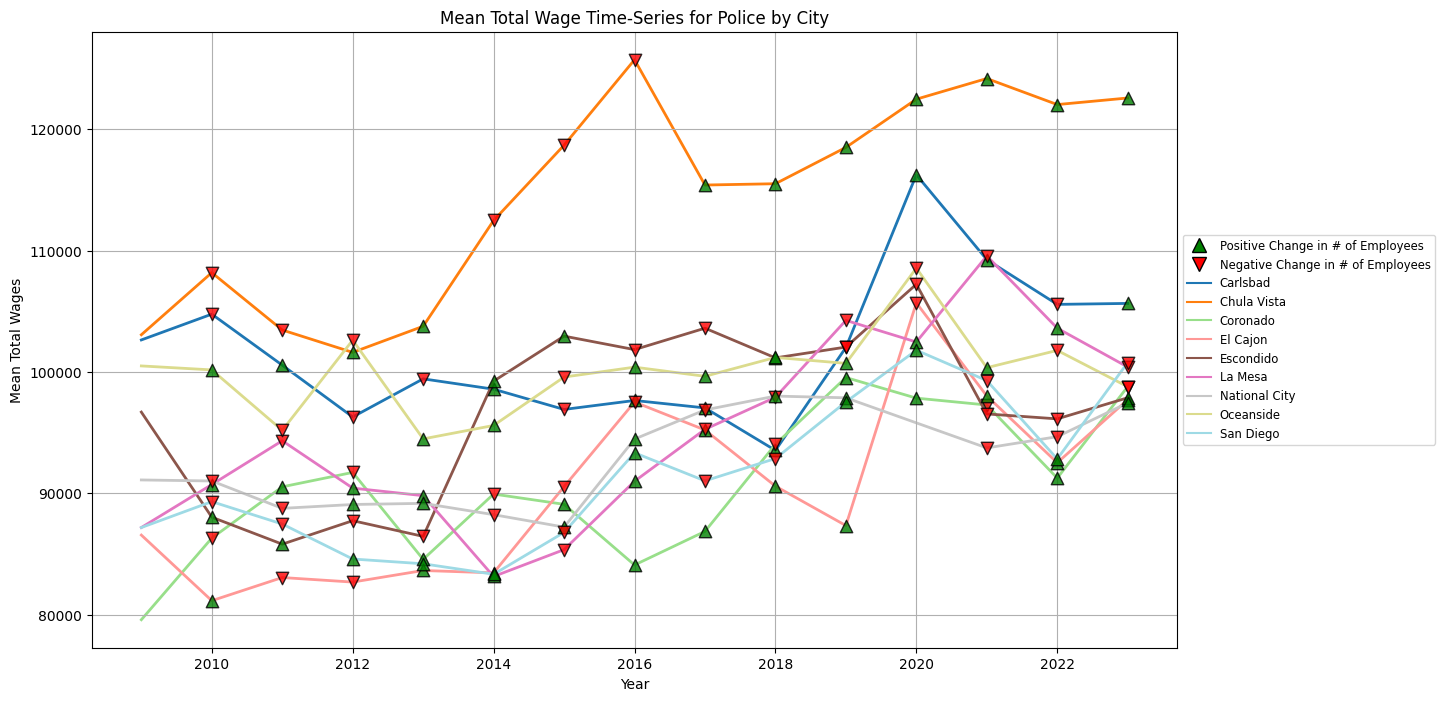

,Year,City,NumEmpls,MeanTotWage,NumEmpls%Chg,MeanTotWage%Chg
0,2009,Carlsbad,119,102643.445378,NaN,NaN
1,2009,Chula Vista,100,103070.420000,NaN,NaN
2,2009,Coronado,43,79584.000000,NaN,NaN
3,2009,El Cajon,103,86560.427184,NaN,NaN
4,2009,Escondido,159,96697.710692,NaN,NaN
...,...,...,...,...,...,...
129,2023,Escondido,154,97877.887273,0.026667,0.018105
130,2023,La Mesa,71,100411.476915,0.000000,-0.030897
131,2023,National City,92,97450.720884,0.022222,0.029381
132,2023,Oceanside,221,98788.809068,-0.026432,-0.029405


In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# If position is not null, filter for that position only
def plot_wage_timeseries(df, position, filter, save_path=None):
    # Convert columns to appropriate types
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['NumEmpls%Chg'] = pd.to_numeric(df['NumEmpls%Chg'], errors='coerce')
    df['MeanTotWage'] = pd.to_numeric(df['MeanTotWage'], errors='coerce')
    
    # Filter by position if provided
    if filter:
        df = df[df['Position'] == filter]
    
    # Get a list of cities in the dataset
    cities = df['City'].unique()
    
    # Use a distinct color map that can generate unique colors for each city
    num_cities = len(cities)
    cmap = plt.get_cmap('tab20', num_cities)  # 'tab20' is good for categorical data with many distinct colors
    
    # Plotting
    plt.figure(figsize=(14, 8))

    city_colors = {}

    for i, city in enumerate(cities):
        city_data = df[df['City'] == city]
        
        # Separate the data into positive and negative employee change
        positive_change = city_data[city_data['NumEmpls%Chg'] > 0]
        negative_change = city_data[city_data['NumEmpls%Chg'] <= 0]
        
        # Assign and store a unique color for each city from the colormap
        color = cmap(i)
        city_colors[city] = color
        
        # Plot time-series for the city without markers on the line
        plt.plot(city_data['Year'], city_data['MeanTotWage'], label=city, color=color, linestyle='-', linewidth=2, zorder=1)
        
        # Overlay smaller markers for positive and negative employee changes with higher zorder
        plt.scatter(positive_change['Year'], positive_change['MeanTotWage'], 
                    color='green', marker='^', s=80, edgecolor='black', alpha=0.8, zorder=2)
        plt.scatter(negative_change['Year'], negative_change['MeanTotWage'], 
                    color='red', marker='v', s=80, edgecolor='black', alpha=0.8, zorder=2)
    
    plt.title(f'Mean Total Wage Time-Series for {position} by City')
    plt.xlabel('Year')
    plt.ylabel('Mean Total Wages')
    
    # Create custom handles for the legend to only show one instance of the markers
    custom_handles = [
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Positive Change in # of Employees', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Negative Change in # of Employees', markeredgecolor='black')
    ]
    
    # Add city-specific handles with unique colors
    city_handles = [plt.Line2D([0], [0], color=city_colors[city], label=city) for city in cities]
    
    plt.legend(handles=custom_handles + city_handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to avoid cutting off the legend
        
    plt.show()

# Example usage with your DataFrame
position = 'Police'
plot_wage_timeseries(grouped_filtered_df, position=position, filter = None, save_path=f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/{position}WagesNumEmployeesViz.pdf")

In [97]:
import pandas as pd
import statsmodels.api as sm

# Convert 'City' to numeric codes if necessary
grouped_filtered_df['City'] = grouped_filtered_df['City'].astype('category').cat.codes
grouped_filtered_df['Year'] = pd.to_numeric(grouped_filtered_df['Year'])

# Create a lagged variable for NumEmpls%Chg by shifting it by 1 year within each city
grouped_filtered_df['NumEmpls%Chg_Lagged'] = grouped_filtered_df.groupby('City')['NumEmpls%Chg'].shift(1)

# Define the dependent variable
y = pd.to_numeric(grouped_filtered_df['MeanTotWage%Chg'], errors='coerce')

# Define the independent variables, including the lagged NumEmpls%Chg
X = grouped_filtered_df[['City', 'Year', 'NumEmpls%Chg']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Drop missing values that resulted from the lagging operation
X = X.dropna()
y = y[X.index]

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        MeanTotWage%Chg   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     7.812
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           8.25e-05
Time:                        14:31:37   Log-Likelihood:                 205.10
No. Observations:                 125   AIC:                            -402.2
Df Residuals:                     121   BIC:                            -390.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.3582      2.135     -0.636   

,Year,City,NumEmpls,MeanTotWage,NumEmpls%Chg,MeanTotWage%Chg,NumEmpls%Chg_Lagged
0,2009,0,119,102643.445378,NaN,NaN,NaN
1,2009,1,100,103070.420000,NaN,NaN,NaN
2,2009,2,43,79584.000000,NaN,NaN,NaN
3,2009,3,103,86560.427184,NaN,NaN,NaN
4,2009,4,159,96697.710692,NaN,NaN,NaN
...,...,...,...,...,...,...,...
129,2023,4,154,97877.887273,0.026667,0.018105,-0.056604
130,2023,5,71,100411.476915,0.000000,-0.030897,0.028986
131,2023,6,92,97450.720884,0.022222,0.029381,-0.021739
132,2023,7,221,98788.809068,-0.026432,-0.029405,-0.008734
